## Лабораторная 5: логистическая регрессия. ROC. AUC. One-hot encoding

## 1
Рассмотрим данные медицинской страховой фирмы. На основе характеристик пациентов `Members.csv` (возраст, пол) и данных о получении медицинского обслуживания в предыдущем году `Claims_Y1.csv` (медицинское учреждение, врач, тип проблемы, количество дней госпитализации, дата, и др. ) нужно предсказать факт госпитализации хотя бы на 1 день в следующем году `DaysInHospital_Y2.csv`.

In [1]:
import pandas as pd

from sklearn import *

%matplotlib inline
import matplotlib.pyplot as plt

Прочтите данные, в качестве параметра index_col используйте `MemberID`. 

* данные из таблицы 'DaysInHospital_Y2.csv' в переменную `days2`
* данные из таблицы 'Members.csv' в переменную `m`
* данные из таблицы 'Claims_Y1.csv' в переменную `claims`

In [2]:
days2 = pd.read_csv('DaysInHospital_Y2.csv', delimiter=',',index_col='MemberID')
m = pd.read_csv('Members.csv', delimiter=',',index_col='MemberID')
claims = pd.read_csv('Claims_Y1.csv', delimiter=',',index_col='MemberID')

days2[:10]

ClaimsTruncated  DaysInHospital
MemberID                                 
98324177                0               0
33899367                1               1
5481382                 0               1
69908334                0               0
29951458                0               0
8169687                 0               0
51315613                0               0
45622725                0               0
56804176                0               0
25842485                0               0

In [3]:
m[:10]

AgeAtFirstClaim  Sex
MemberID                     
14723353           70-79    M
75706636           70-79    M
17320609           70-79    M
69690888           40-49    M
33004608             0-9    M
63690883           40-49    F
50065607           30-39    M
34270657           70-79    F
75299016           40-49  NaN
22358692             0-9    M

In [4]:
claims[:10]

ProviderID    Vendor      PCP Year           Specialty  \
MemberID                                                           
42286978   8013252.0  172193.0  37796.0   Y1             Surgery   
99829076   6721023.0  265273.0  91972.0   Y1      Rehabilitation   
54666321   9932074.0   35565.0  27294.0   Y1  Diagnostic Imaging   
66951188   4699470.0  179509.0  75876.0   Y1  Diagnostic Imaging   
78859054   9121540.0  523791.0  21579.0   Y1           Emergency   
26477481   8362269.0  682053.0  20090.0   Y1           Emergency   
83695244   5244762.0  791272.0  32724.0   Y1            Internal   
63063005   2864249.0  167772.0  35832.0   Y1  Diagnostic Imaging   
34087464   7990212.0       NaN  91972.0   Y1    General Practice   
33385188   7053364.0  240043.0  68968.0   Y1          Laboratory   

                    PlaceSvc PayDelay LengthOfStay          DSFS  \
MemberID                                                           
42286978              Office       28          NaN   8- 9 months   
99829076              Office     162+          NaN    0- 1 month   
54666321              Office       29          NaN    0- 1 month   
66951188  Inpatient Hospital       51          NaN    0- 1 month   
78859054         Urgent Care       22        1 day   6- 7 months   
26477481         Urgent Care      143          NaN    0- 1 month   
83695244              Office     162+          NaN    0- 1 month   
63063005         Urgent Care       62          NaN  10-11 months   
34087464         Urgent Care       46          NaN   4- 5 months   
33385188     Independent Lab       24          NaN   6- 7 months   

         PrimaryConditionGroup CharlsonIndex ProcedureGroup  SupLOS  
MemberID                                                             
42286978               NEUMENT             0            MED       0  
99829076                TRAUMA             0            MED       0  
54666321                RESPR4             0            RAD       0  
66951188                 ROAMI             0            RAD       0  
78859054                HEART2             0            SDS       0  
26477481                 ROAMI           1-2             EM       0  
83695244               MISCHRT             0             EM       0  
63063005                 PNEUM           1-2            RAD       0  
34087464              GIOBSENT           1-2            SCS       0  
33385188                HEART2           1-2             PL       0

## 2
Чтобы анонимизировать данные организатор указал приблизительную информацию о пациентах, например в столбце возраст указаны возрастные группы: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Преобразуем строковые признаки в количественные и заменим пропущенные значения:

In [5]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})


In [6]:
m[:10]

AgeAtFirstClaim Sex
MemberID                     
14723353               70   M
75706636               70   M
17320609               70   M
69690888               40   M
33004608                0   M
63690883               40   F
50065607               30   M
34270657               70   F
75299016               40   N
22358692                0   M

In [7]:
claims[:10]

ProviderID    Vendor      PCP Year           Specialty  \
MemberID                                                           
42286978   8013252.0  172193.0  37796.0   Y1             Surgery   
99829076   6721023.0  265273.0  91972.0   Y1      Rehabilitation   
54666321   9932074.0   35565.0  27294.0   Y1  Diagnostic Imaging   
66951188   4699470.0  179509.0  75876.0   Y1  Diagnostic Imaging   
78859054   9121540.0  523791.0  21579.0   Y1           Emergency   
26477481   8362269.0  682053.0  20090.0   Y1           Emergency   
83695244   5244762.0  791272.0  32724.0   Y1            Internal   
63063005   2864249.0  167772.0  35832.0   Y1  Diagnostic Imaging   
34087464   7990212.0       NaN  91972.0   Y1    General Practice   
33385188   7053364.0  240043.0  68968.0   Y1          Laboratory   

                    PlaceSvc PayDelay  LengthOfStay          DSFS  \
MemberID                                                            
42286978              Office       28             0   8- 9 months   
99829076              Office     162+             0    0- 1 month   
54666321              Office       29             0    0- 1 month   
66951188  Inpatient Hospital       51             0    0- 1 month   
78859054         Urgent Care       22             1   6- 7 months   
26477481         Urgent Care      143             0    0- 1 month   
83695244              Office     162+             0    0- 1 month   
63063005         Urgent Care       62             0  10-11 months   
34087464         Urgent Care       46             0   4- 5 months   
33385188     Independent Lab       24             0   6- 7 months   

         PrimaryConditionGroup  CharlsonIndex ProcedureGroup  SupLOS  
MemberID                                                              
42286978               NEUMENT              0            MED       0  
99829076                TRAUMA              0            MED       0  
54666321                RESPR4              0            RAD       0  
66951188                 ROAMI              0            RAD       0  
78859054                HEART2              0            SDS       0  
26477481                 ROAMI              1             EM       0  
83695244               MISCHRT              0             EM       0  
63063005                 PNEUM              1            RAD       0  
34087464              GIOBSENT              1            SCS       0  
33385188                HEART2              1             PL       0

## 3
Сконструируем признаки по массиву случаев медицинского обслуживания: 
* `f_Charlson` — максимальный индекс коморбидности Чальсона по всем случаям для пациента (`CharlsonIndex` в таблице `claims`)
* `f_LengthOfStay` — суммарное количество дней госпитализации в прошлом году (`LengthOfStay` в таблице `claims`) 

*Функции, которые могут пригодиться при решении: `.groupby(['MemberID']), .max(), .sum()`* 

In [23]:
f_Charlson = claims.CharlsonIndex.groupby(['MemberID']).max()
f_LengthOfStay = claims.CharlsonIndex.groupby(['MemberID']).sum()

f_Charlson.head(5)

MemberID
210     0
3197    0
3889    1
4187    0
9063    0
Name: CharlsonIndex, dtype: int64

In [24]:
f_LengthOfStay.head(5)

MemberID
210     0
3197    0
3889    4
4187    0
9063    0
Name: CharlsonIndex, dtype: int64

## 4

Составим матрицу объектов признаков со столбцами: `f_Charlson`, `f_LengthOfStay`, возраст пациента, `ClaimsTruncated` (не оказалось ли случаев медицинского обслуживания слишком много):

*Функции, которые могут пригодиться при решении: `.join()`*

In [31]:
data = days2
data = data.join(f_Charlson)
data = data.rename(columns = {'CharlsonIndex': 'f_Charlson'}, inplace = False)
data = data.join(f_LengthOfStay)
data = data.rename(columns = {'CharlsonIndex': 'f_LengthOfStay'}, inplace = False)
data = data.join(m['AgeAtFirstClaim'])

# место для кода
data.head(5)

ClaimsTruncated  DaysInHospital  f_Charlson  f_LengthOfStay  \
MemberID                                                                
98324177                0               0           0               0   
33899367                1               1           0               0   
5481382                 0               1           0               0   
69908334                0               0           0               0   
29951458                0               0           0               0   

          AgeAtFirstClaim  
MemberID                   
98324177               30  
33899367               80  
5481382                20  
69908334               60  
29951458               40

## 5
Составим функцию, которая будет делить выборку на две части `dataTrain` и `dataTest`, обучать логистическую регрессию на `dataTrain`, применять к `dataTest`, строить кривую ошибок и считать под ней площадь:

In [32]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print( metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1]) )

## 6
Применим данную функцию к `data`:

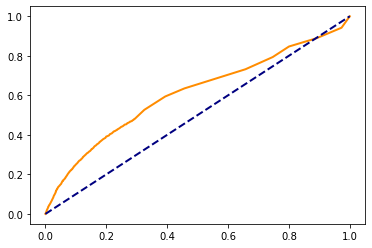

0.6096308023531228


In [33]:
calcAUC(data)

## 7
Логистическая регрессия принимает на вход только количественные признаки.

Добавим к нашим данным пол пациента, применив one hot encoding:

*Функции, которые могут пригодиться при решении: `pd.get_dummies(m.Sex, prefix='pol')`* 

In [41]:
data2 = data.join(pd.get_dummies(m.Sex, prefix='pol'))
data2[:5]

ClaimsTruncated  DaysInHospital  f_Charlson  f_LengthOfStay  \
MemberID                                                                
98324177                0               0           0               0   
33899367                1               1           0               0   
5481382                 0               1           0               0   
69908334                0               0           0               0   
29951458                0               0           0               0   

          AgeAtFirstClaim  pol_F  pol_M  pol_N  
MemberID                                        
98324177               30      0      1      0  
33899367               80      1      0      0  
5481382                20      1      0      0  
69908334               60      1      0      0  
29951458               40      0      1      0

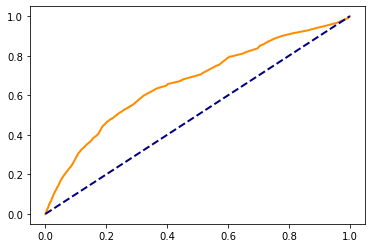

0.66706329365051


In [42]:
calcAUC(data2)

## 8
Попытайтесь применить  one hot encoding к уже существующим в `data2` признакам или составить новые признаки по массиву `claims`.

In [43]:
data3 = data2.join(pd.get_dummies(claims.Specialty, prefix='spec'))
data3[:5]

ClaimsTruncated  DaysInHospital  f_Charlson  f_LengthOfStay  \
MemberID                                                                
210                     0               0           0               0   
210                     0               0           0               0   
210                     0               0           0               0   
210                     0               0           0               0   
210                     0               0           0               0   

          AgeAtFirstClaim  pol_F  pol_M  pol_N  spec_Anesthesiology  \
MemberID                                                              
210                    30      0      0      1                    0   
210                    30      0      0      1                    0   
210                    30      0      0      1                    0   
210                    30      0      0      1                    0   
210                    30      0      0      1                    0   

          spec_Diagnostic Imaging  spec_Emergency  spec_General Practice  \
MemberID                                                                   
210                             0               0                      0   
210                             0               1                      0   
210                             0               0                      0   
210                             0               1                      0   
210                             0               0                      0   

          spec_Internal  spec_Laboratory  spec_Obstetrics and Gynecology  \
MemberID                                                                   
210                   1                0                               0   
210                   0                0                               0   
210                   1                0                               0   
210                   0                0                               0   
210                   1                0                               0   

          spec_Other  spec_Pathology  spec_Pediatrics  spec_Rehabilitation  \
MemberID                                                                     
210                0               0                0                    0   
210                0               0                0                    0   
210                0               0                0                    0   
210                0               0                0                    0   
210                0               0                0                    0   

          spec_Surgery  
MemberID                
210                  0  
210                  0  
210                  0  
210                  0  
210                  0

/home/margarita/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


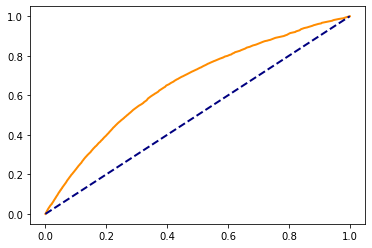

0.6603536608964591


In [44]:
calcAUC(data3)

In [45]:
data4 = data2.join(pd.get_dummies(data2.DaysInHospital, prefix='days'))
data4[:5]

ClaimsTruncated  DaysInHospital  f_Charlson  f_LengthOfStay  \
MemberID                                                                
98324177                0               0           0               0   
33899367                1               1           0               0   
5481382                 0               1           0               0   
69908334                0               0           0               0   
29951458                0               0           0               0   

          AgeAtFirstClaim  pol_F  pol_M  pol_N  days_0  days_1  
MemberID                                                        
98324177               30      0      1      0       1       0  
33899367               80      1      0      0       0       1  
5481382                20      1      0      0       0       1  
69908334               60      1      0      0       1       0  
29951458               40      0      1      0       1       0

/home/margarita/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


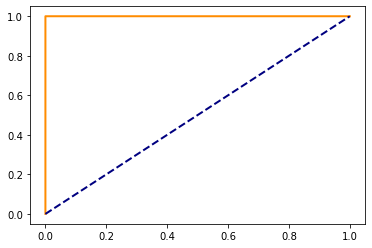

0.9999999999999999


In [47]:
calcAUC(data4)

Построившему матрицу объектов признаков, для которой логистическая регрессия работает с наилучшим качеством: +5 бонусных баллов.